# FDSN webservice with Obspy- Dataselect service

In this tutorial we will get the waveform data for stations at Whakaari/White Island for several, small explosive eruptions.

### Getting Started - Import Modules

In [1]:
import obspy
from obspy.clients.fdsn import Client as FDSN_Client

### Define GeoNet FDSN client

In [2]:
client = FDSN_Client("GEONET")

## Accessing Waveforms
Use the **dataselect** service to access waveforms from the archive.

Data are returned as a stream object, which is made up of a number of traces. 

You can filter data requests by time, station, channel, etc, and you can use UNIX wildcards in the request.

This first example requests 5 minutes (300 seconds) of waveforms recorded at THZ at the time of the 2016 Kaikoura earthquake. This station has two sensors, with location codes 10 and 21, and each provides three components of data. `*` matches all location codes, and `HH?` matches all component names that start with `HH`. We also request the instrument response.

4 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2019-12-09T01:10:00.003130Z - 2019-12-09T01:17:00.003130Z | 100.0 Hz, 42001 samples
NZ.WIZ.30.HDF  | 2019-12-09T01:10:00.003130Z - 2019-12-09T01:17:00.003130Z | 100.0 Hz, 42001 samples
NZ.WSRZ.10.HHZ | 2019-12-09T01:10:00.003129Z - 2019-12-09T01:17:00.003129Z | 100.0 Hz, 42001 samples
NZ.WSRZ.30.HDF | 2019-12-09T01:10:00.003129Z - 2019-12-09T01:17:00.003129Z | 100.0 Hz, 42001 samples


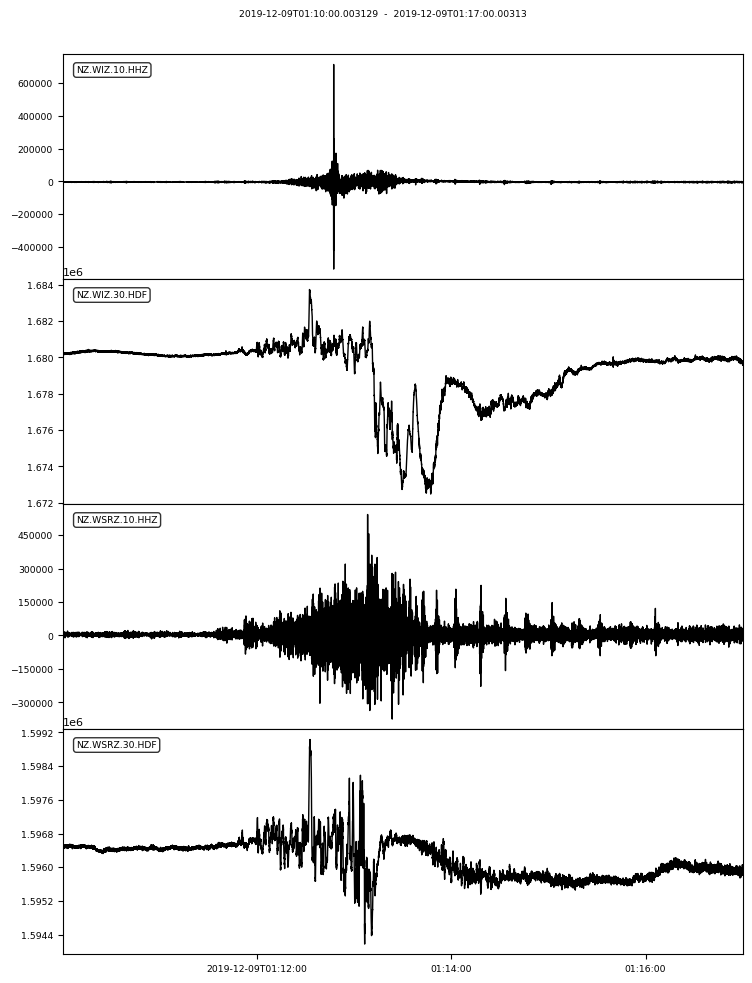

In [118]:
#t = obspy.UTCDateTime("2012-08-04T16:40:00.000")

#eruption = {'startt':obspy.UTCDateTime("2012-08-04T16:52:00.000"), 'pretrigger':600, 'duration':600, 'pad':600}
pad = 0
eruption = {'startt':obspy.UTCDateTime("2019-12-09T01:11:00.000"), 'pretrigger':60, 'duration':360}
ts = eruption['startt'] - eruption['pretrigger'] 
te = eruption['startt'] + eruption['duration'] 

st = obspy.Stream()
for station in ['WIZ', 'WSRZ']:
    # Load any seismic data - Z-component only
    try:
        st_seismic = client.get_waveforms("NZ", station, "*", "HHZ", ts - pad, te + pad, attach_response=True)
    except Exception as e1:
        print(e1)
        
    else:
        st.append(st_seismic[0])
    # Load any acoustic data
    try:
        st_acoustic = client.get_waveforms("NZ", station, "*", "HDF", ts - pad, te + pad, attach_response=True)
    except Exception as e2:
        print(e2)
    else:
        st.append(st_acoustic[0])        
print(st)
st.plot(equal_scale=False);

Plot the first three channels which are ground velocity, and then the next three which are ground acceleration

### Remove instrument response

We remove the instrument response from the acceleration records so that we can determine the peak ground accelerations measured on each channel.

In [75]:
pre_filt = (0.05, 0.08, 20, 25)
raw_seismic = st.select(component='Z')
raw_infrasound = st.select(component='F')
#acc = raw_seismic.copy()
vel = raw_seismic.copy()
disp = raw_seismic.copy()
pres = raw_infrasound.copy()
#acc.remove_response(output='ACC', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
vel.remove_response(output='VEL', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
disp.remove_response(output='DISP', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
pres.filter('bandpass', freqmin=pre_filt[1], freqmax=pre_filt[2])
pres.remove_sensitivity().trim(starttime=ts, endtime=te)
for tr in pres:
    tr.data = tr.data * 100
#acc.plot(equal_scale=False);
vel.plot(equal_scale=False, outfile='/Users/thompsong/Dropbox/BRIEFCASE/20191209_velocity_seismogram.png');
pres.plot(equal_scale=False, outfile='/Users/thompsong/Dropbox/BRIEFCASE/20191209_pressure_seismogram.png');
disp.plot(equal_scale=False, outfile='/Users/thompsong/Dropbox/BRIEFCASE/20191209_displacement_seismogram.png');

#print(f'PGA = {acc.max():.2e} m/s^2, PGV = {vel.max():.2e} m/s, PGD = {disp.max():.2e} m, PP = {pres.max():.2e} Pa' )

(<Figure size 576x756 with 5 Axes>,
 array([<Axes: >, <Axes: ylabel='     WIZ.HHZ'>, <Axes: >,
        <Axes: xlabel='Time [s]', ylabel='     WSRZ.HHZ'>], dtype=object))

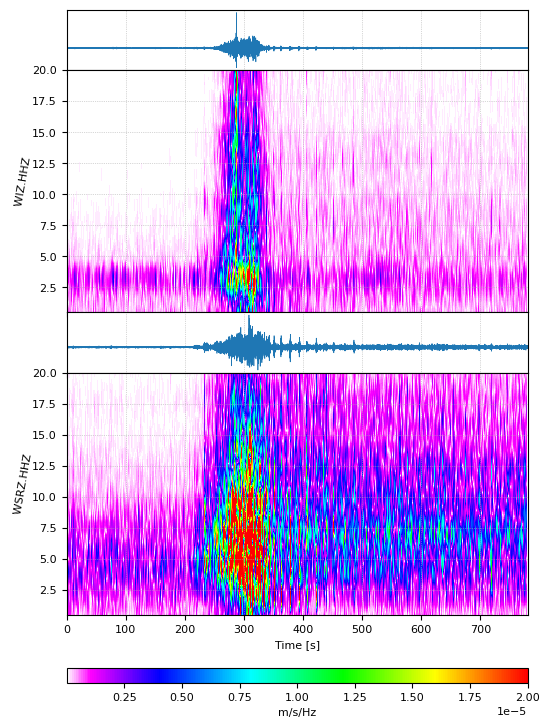

In [81]:
#vel.spectrogram()
sys.path.append('/Users/thompsong/Developer/old/GitHub/tremorExplorer/lib')
import Spectrograms
velspobj=Spectrograms.icewebSpectrogram(vel)
velspobj.plot(outfile='/Users/thompsong/Dropbox/BRIEFCASE/20191209_velocity_spectrogram.png', equal_scale=True, clim=[0, 2e-5])

(<Figure size 576x756 with 5 Axes>,
 array([<Axes: >, <Axes: ylabel='     WIZ.HDF'>, <Axes: >,
        <Axes: xlabel='Time [s]', ylabel='     WSRZ.HDF'>], dtype=object))

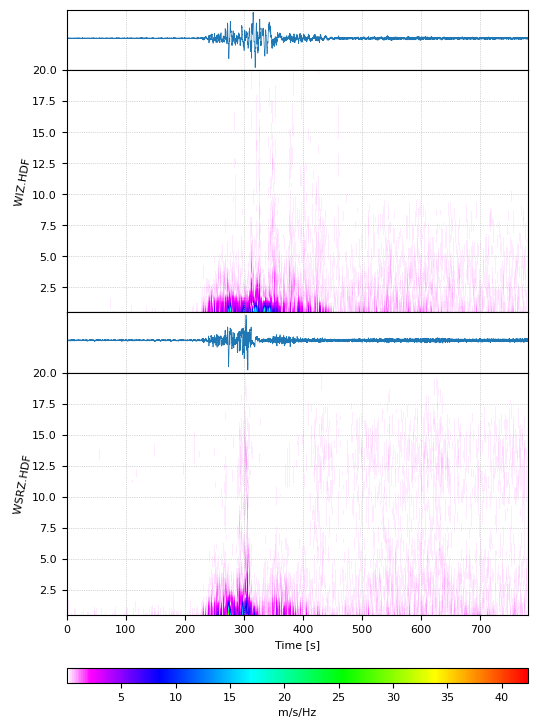

In [78]:
presspobj=Spectrograms.icewebSpectrogram(pres)
    sys.path.append('/Users/thompsong/Developer/old/GitHub/tremorExplorer/lib')
    import Spectrogramspresspobj.plot(outfile='/Users/thompsong/Dropbox/BRIEFCASE/20191209_pressure_spectrogram.png', equal_scale=True)

No data available for request.
HTTP Status code: 204
Detailed response of server:


No data available for request.
HTTP Status code: 204
Detailed response of server:


2 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2012-08-04T16:38:59.998394Z - 2012-08-04T17:16:59.998394Z | 100.0 Hz, 228001 samples
NZ.WIZ.30.HDF | 2012-08-04T16:38:59.998394Z - 2012-08-04T17:16:59.998394Z | 100.0 Hz, 228001 samples
4 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2013-08-19T22:09:59.998394Z - 2013-08-19T22:47:59.998394Z | 100.0 Hz, 228001 samples
NZ.WIZ.30.HDF  | 2013-08-19T22:09:59.998394Z - 2013-08-19T22:47:59.998394Z | 100.0 Hz, 228001 samples
NZ.WSRZ.10.HHZ | 2013-08-19T22:09:59.998391Z - 2013-08-19T22:47:59.998391Z | 100.0 Hz, 228001 samples
NZ.WSRZ.30.HDF | 2013-08-19T22:09:59.998391Z - 2013-08-19T22:47:59.998391Z | 100.0 Hz, 228001 samples
4 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2013-10-03T03:21:59.998341Z - 2013-10-03T03:59:59.998341Z | 100.0 Hz, 228001 samples
NZ.WIZ.30.HDF  | 2013-10-03T03:21:59.998339Z - 2013-10

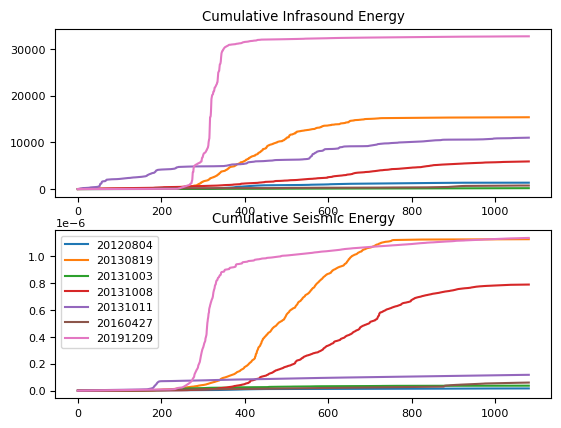

In [116]:
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/Users/thompsong/Developer/old/GitHub/tremorExplorer/lib')
import Spectrograms
pad = 600
pretrigger = 180
duration = 900
eruption_times = [
    obspy.UTCDateTime("2012-08-04T16:52:00.000"), 
    obspy.UTCDateTime("2013-08-19T22:23:00.000"), 
    obspy.UTCDateTime("2013-10-03T03:35:00.000"), 
    obspy.UTCDateTime("2013-10-08T02:05:00.000"), 
    obspy.UTCDateTime("2013-10-11T07:09:00.000"), 
    obspy.UTCDateTime("2016-04-27T09:37:00.000"), 
    obspy.UTCDateTime("2019-12-09T01:11:00.000"),
]

vel_all = obspy.Stream()
disp_all = obspy.Stream()
pres_all = obspy.Stream()

filler = np.zeros(60*100)

fh, axh = plt.subplots(2,1)

for eruption_time in eruption_times:
    ts = eruption_time - pretrigger
    te = eruption_time + duration
    YYYYMMDD = eruption_time.strftime('%Y%m%d')
    
    st = obspy.Stream()
    for station in ['WIZ', 'WSRZ']:
        # Load any seismic data - Z-component only
        try:
            st_seismic = client.get_waveforms("NZ", station, "*", "HHZ", ts - pad, te + pad, attach_response=True)
        except Exception as e1:
            print(e1)
            
        else:
            st.append(st_seismic[0])
        # Load any acoustic data
        try:
            st_acoustic = client.get_waveforms("NZ", station, "*", "HDF", ts - pad, te + pad, attach_response=True)
        except Exception as e2:
            print(e2)
        else:
            st.append(st_acoustic[0])        
    print(st)
    #st.plot(equal_scale=False);

    # FILTER & CORRECT
    pre_filt = (0.05, 0.08, 20, 25)
    raw_seismic = st.select(component='Z')
    raw_infrasound = st.select(component='F')
    #acc = raw_seismic.copy()
    vel = raw_seismic.copy()
    disp = raw_seismic.copy()
    pres = raw_infrasound.copy()
    #acc.remove_response(output='ACC', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    vel.remove_response(output='VEL', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    disp.remove_response(output='DISP', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    pres.filter('bandpass', freqmin=pre_filt[1], freqmax=pre_filt[2])
    pres.remove_sensitivity().trim(starttime=ts, endtime=te)
    for tr in pres:
        tr.data = tr.data * 100
    #acc.plot(equal_scale=False);
    '''
    vel.plot(equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/{YYYYMMDD}_velocity_seismogram.png', log=True);
    pres.plot(equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/{YYYYMMDD}_pressure_seismogram.png', log=True);
    disp.plot(equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/{YYYYMMDD}_displacement_seismogram.png', log=True);

    # SPECTROGRAMS
    #vel.spectrogram()

    velspobj=Spectrograms.icewebSpectrogram(vel)
    velspobj.plot(outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/{YYYYMMDD}_velocity_spectrogram.png', dbscale=True, clim=[1e-7, 2e-5], title=ts.strftime('%Y-%m-%d %H:%M:%S'))
    
    presspobj=Spectrograms.icewebSpectrogram(pres)
    presspobj.plot(outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/{YYYYMMDD}_pressure_spectrogram.png', dbscale=True, clim=[0.1, 50], title=ts.strftime('%Y-%m-%d %H:%M:%S'))
    '''
    seismicE = vel.copy()
    for tr in seismicE:
        tr.data = np.cumsum(np.multiply(tr.data, tr.data))/tr.stats.sampling_rate
    
    infraE = pres.copy()
    for tr in infraE:
        tr.data = np.cumsum(np.multiply(tr.data, tr.data))/tr.stats.sampling_rate  

    axh[0].plot(infraE[0].times(), infraE[0].data, label=YYYYMMDD)
    axh[1].plot(seismicE[-1].times(), seismicE[-1].data, label=YYYYMMDD)
    
    if len(vel_all)==0:
        vel_all = vel
        disp_all = disp
        pres_all = pres
        seismicE_all = seismicE
        infraE_all = infraE
        
        tr = vel_all[0].copy()
        tr.id = 'NZ.WSRZ.10.HHZ'
        tr.data = np.zeros(vel_all[0].stats.npts)
        vel_all.append(tr)

        tr = disp_all[0].copy()
        tr.id = 'NZ.WSRZ.10.HHZ'
        tr.data = np.zeros(disp_all[0].stats.npts)
        disp_all.append(tr)

        tr = pres_all[0].copy()
        tr.id = 'NZ.WSRZ.30.HDF'
        tr.data = np.zeros(pres_all[0].stats.npts)
        pres_all.append(tr)

        seismicE_all.append(vel_all[1].copy())
        infraE_all.append(pres_all[1].copy())
        
    
    
    else:
        for tr in vel:
            for all_tr in vel_all:
                if all_tr.id == tr.id:
                    y = np.append(tr.data, filler)
                    all_tr.data = np.append(all_tr.data, y)
                
        for tr in disp:
            for all_tr in disp_all:
                if all_tr.id == tr.id:
                    y = np.append(tr.data, filler)
                    all_tr.data = np.append(all_tr.data, y)   
        for tr in pres:
            for all_tr in pres_all:
                if all_tr.id == tr.id:
                    y = np.append(tr.data, filler)
                    all_tr.data = np.append(all_tr.data, y)

        for tr in seismicE:
            for all_tr in seismicE_all:
                if all_tr.id == tr.id:
                    y = np.append(tr.data, filler)
                    all_tr.data = np.append(all_tr.data, y)
        
        for tr in infraE:
            for all_tr in infraE_all:
                if all_tr.id == tr.id:
                    y = np.append(tr.data, filler)
                    all_tr.data = np.append(all_tr.data, y)
axh[0].set_title('Cumulative Infrasound Energy')
axh[1].set_title('Cumulative Seismic Energy')
plt.legend()
plt.savefig(f'/Users/thompsong/Dropbox/BRIEFCASE/energy_comparison.png', bbox_inches='tight')
plt.show()


In [ ]:
plt.show()

In [111]:
vel_all.plot(method='full', type='relative', equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/velocity_seismograms_comparison.png');
disp_all.plot(method='full', type='relative', equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/displacement_seismograms_comparison.png');
pres_all.plot(method='full', type='relative', equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/pressure_seismograms_comparison.png');
seismicE_all.plot(method='full', type='relative', equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/seismicE_comparison.png');
infraE_all.plot(method='full', type='relative', equal_scale=False, outfile=f'/Users/thompsong/Dropbox/BRIEFCASE/infraE_comparison.png');



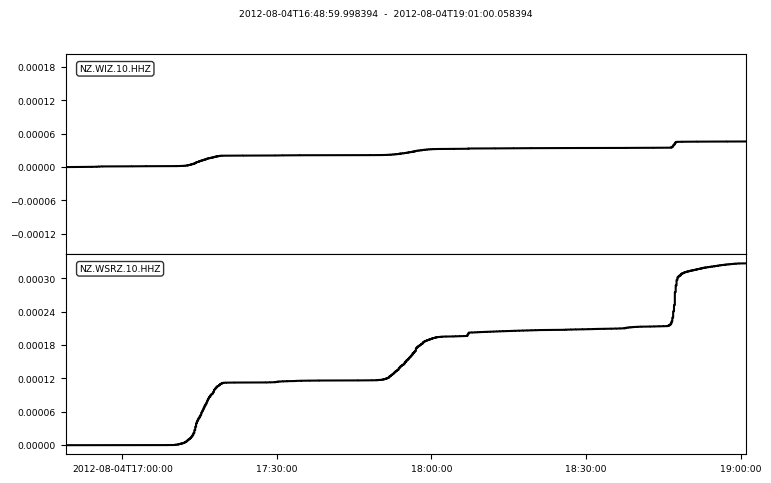

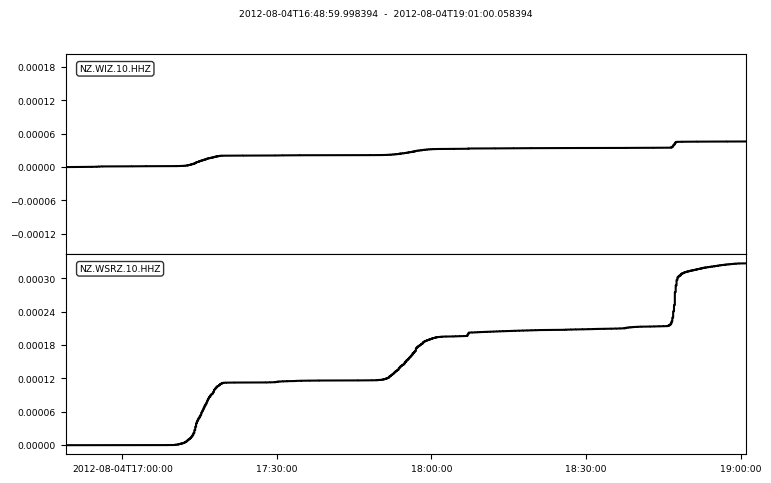

In [109]:
energy_all = vel_all.copy()
for tr in energy_all:
    tr.data = np.cumsum(np.multiply(tr.data, tr.data))
    
energy_all.plot(equal_scale=False)




In [53]:
# Compute VSAM and DSAM, 10-second
####################### Common header #########################
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import SAM
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().parents[1].joinpath('data','continuous','SAM')
###############################################################
vel.stats['units'] = 'm/s'
print(vel.stats)
vsamObj = SAM.VSAM(stream=obspy.Stream(vel), sampling_interval=10)

               network: NZ
               station: WIZ
              location: 10
               channel: HHZ
             starttime: 2019-12-08T01:11:00.003131Z
               endtime: 2019-12-09T02:11:00.003131Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 9000001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 27860, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 14264320})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2019, 12, 9, 2, 21, 0, 3131)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 12, 8, 1, 1, 0, 3131))', "ObsPy 1.4.0: remove_response(fig=None::inventory=None::output='VEL'::plot=False::pre_filt=(0.05, 0.08, 20, 25)::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", 'ObsPy 1.4.0:

### Coastal sea level gauge example

The same procedure for accessing waveform from a FDSN waveserver applies to data from coastal sea level gauges. We'll get data from `GIST`, the gauge at Gisborne. The location code is `40` and the component is `BTH`. We retrieve a day of data from 2022-01-15, the day of the Hunga Tonga - Hunga Ha'apai volcanic eruption generated tsunami. 

No data available for request.
HTTP Status code: 204
Detailed response of server:


No data available for request.
HTTP Status code: 204
Detailed response of server:


2 Trace(s) in Stream:
NZ.WIZ.10.HHZ | 2012-08-01T16:41:59.998394Z - 2012-08-04T18:01:59.998394Z | 100.0 Hz, 26400001 samples
NZ.WIZ.30.HDF | 2012-08-01T16:41:59.998394Z - 2012-08-04T18:01:59.998394Z | 100.0 Hz, 26400001 samples
4 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2013-08-16T22:12:59.998394Z - 2013-08-19T23:32:59.998394Z | 100.0 Hz, 26400001 samples
NZ.WIZ.30.HDF  | 2013-08-16T22:12:59.998394Z - 2013-08-19T23:32:59.998394Z | 100.0 Hz, 26400001 samples
NZ.WSRZ.10.HHZ | 2013-08-16T22:12:59.998393Z - 2013-08-19T23:32:59.998393Z | 100.0 Hz, 26400001 samples
NZ.WSRZ.30.HDF | 2013-08-16T22:12:59.998393Z - 2013-08-19T23:32:59.998393Z | 100.0 Hz, 26400001 samples
4 Trace(s) in Stream:
NZ.WIZ.10.HHZ  | 2013-09-30T03:24:59.998389Z - 2013-10-03T04:44:59.998389Z | 100.0 Hz, 26400001 samples
NZ.WIZ.30.HDF  | 2013-09-30T03:24:59.998

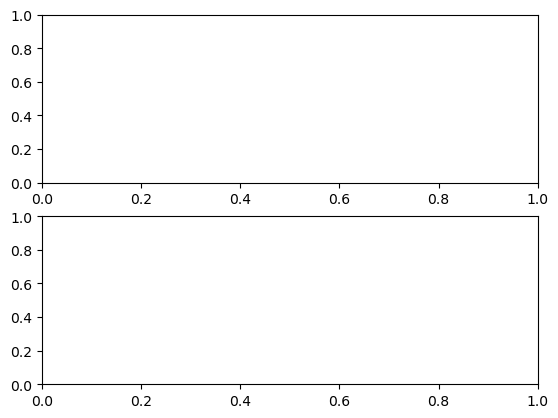

In [4]:
# Download 3 days of data


import numpy as np
import matplotlib.pyplot as plt
pad = 600
pretrigger = 60 * 60 * 24 * 3
duration = 3600
eruption_times = [
    obspy.UTCDateTime("2012-08-04T16:52:00.000"), 
    obspy.UTCDateTime("2013-08-19T22:23:00.000"), 
    obspy.UTCDateTime("2013-10-03T03:35:00.000"), 
    obspy.UTCDateTime("2013-10-08T02:05:00.000"), 
    obspy.UTCDateTime("2013-10-11T07:09:00.000"), 
    obspy.UTCDateTime("2016-04-27T09:37:00.000"), 
    obspy.UTCDateTime("2019-12-09T01:11:00.000"),
]

vel_all = obspy.Stream()
disp_all = obspy.Stream()
pres_all = obspy.Stream()

filler = np.zeros(60*100)

fh, axh = plt.subplots(2,1)

for eruption_time in eruption_times:
    ts = eruption_time - pretrigger
    te = eruption_time + duration
    YYYYMMDD = eruption_time.strftime('%Y%m%d')
    
    st = obspy.Stream()
    for station in ['WIZ', 'WSRZ']:
        # Load any seismic data - Z-component only
        try:
            st_seismic = client.get_waveforms("NZ", station, "*", "HHZ", ts - pad, te + pad, attach_response=True)
        except Exception as e1:
            print(e1)
            
        else:
            st.append(st_seismic[0])
        # Load any acoustic data
        try:
            st_acoustic = client.get_waveforms("NZ", station, "*", "HDF", ts - pad, te + pad, attach_response=True)
        except Exception as e2:
            print(e2)
        else:
            st.append(st_acoustic[0])        
    print(st)
    #st.plot(equal_scale=False);

    # FILTER & CORRECT
    pre_filt = (0.05, 0.08, 20, 25)
    raw_seismic = st.select(component='Z')
    raw_infrasound = st.select(component='F')
    acc = raw_seismic.copy()
    vel = raw_seismic.copy()
    disp = raw_seismic.copy()
    pres = raw_infrasound.copy()
    acc.remove_response(output='ACC', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    vel.remove_response(output='VEL', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    disp.remove_response(output='DISP', pre_filt=pre_filt).trim(starttime=ts, endtime=te)
    pres.filter('bandpass', freqmin=pre_filt[1], freqmax=pre_filt[2])
    pres.remove_sensitivity().trim(starttime=ts, endtime=te)
    for tr in pres:
        tr.data = tr.data * 100

    vel.write(f'/Users/thompsong/data/{YYYYMMDD}_velocity_seismogram.pkl', format='pickle')
    pres.write(f'/Users/thompsong/data/{YYYYMMDD}_acoustogram.pkl', format='pickle')
    disp.write(f'/Users/thompsong/data/{YYYYMMDD}_displacement_seismogram.pkl', format='pickle')
    acc.write(f'/Users/thompsong/data/{YYYYMMDD}_acceleration_seismogram.pkl', format='pickle')
    


In [6]:
t = UTCDateTime("2022-01-15T05:00:00.000")
st = client.get_waveforms("NZ", "GIST","40", "BTH", t, t + 86400,attach_response=True)
print(st)

1 Trace(s) in Stream:
NZ.GIST.40.BTH | 2022-01-15T05:00:00.000000Z - 2022-01-16T05:00:00.000000Z | 10.0 Hz, 864001 samples


Remove the sensitivity to convert the vaues into metres of water above the sensor.

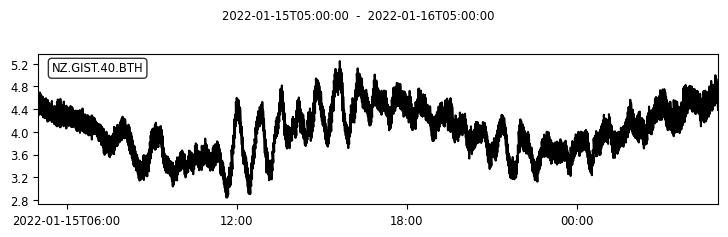

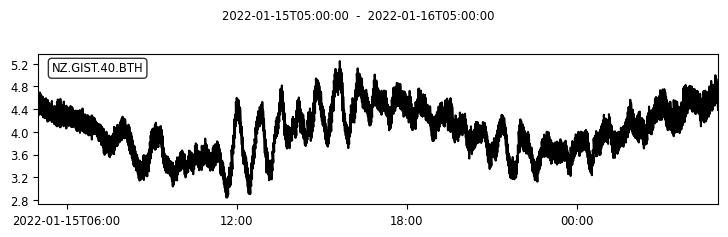

In [7]:
st.remove_sensitivity()
st.plot()

### Day length plot

Another common request is to view an entire day worth of data at a site.
This example shows a swarm of volcanic at Mt Ruapehu in 2016. We retrieve 86400 seconds, equivalent of a whole day, of data.

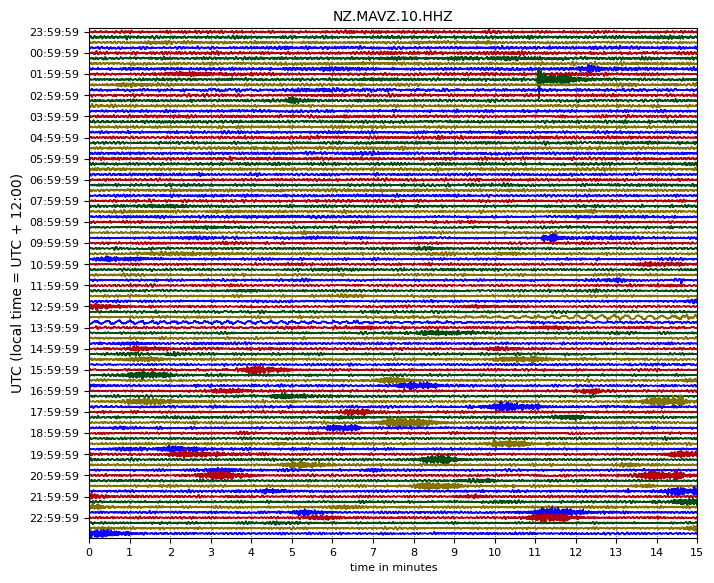

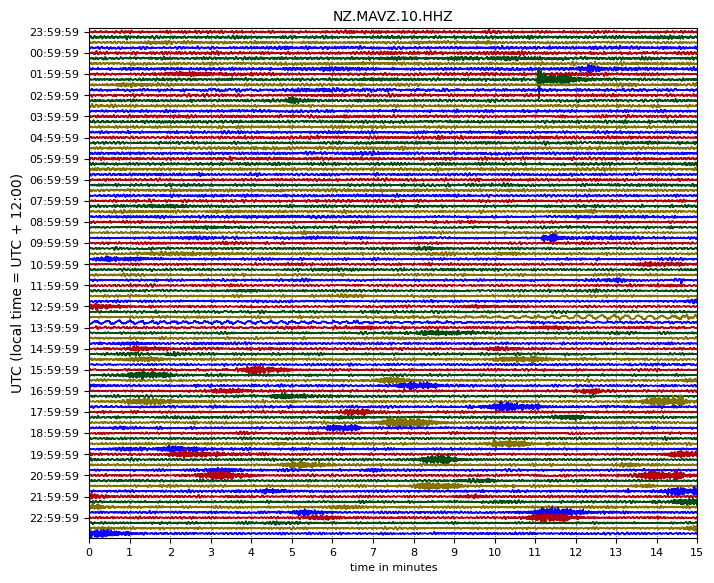

In [8]:
t = UTCDateTime("2016-04-27T00:00:00.000")
st = client.get_waveforms("NZ", "MAVZ","10", "HHZ", t, t + 86400)
st.plot(type="dayplot")

### Spectrogram plots

These are also easy with obspy. We request 1 hour (3600 seconds) of data. While a spectrogram can be plotted for any data window, it becomes very slow for longer windows. One hour of data takes several seconds to plot, and much longer windows are not recommended.

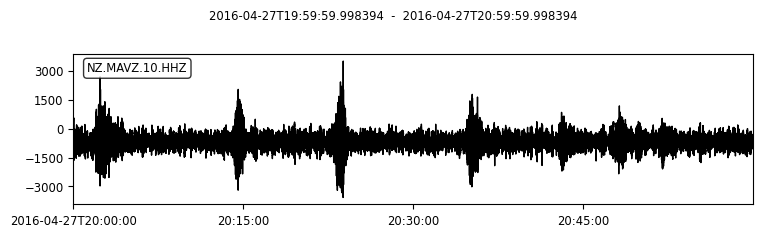

<Figure size 432x288 with 0 Axes>

[None]

In [9]:
t = UTCDateTime("2016-04-27T20:00:00.000")
st.trim(t,t+3600)
st.plot() 
st.spectrogram(log=True)

### Day length plot for most recent data

At the beginning of this workbook we defined two clients. One for the archive services, which we have been using so far, and the other for the near real-time service. This example uses the near real-time service to show the most recent day's data recorded at a site. 

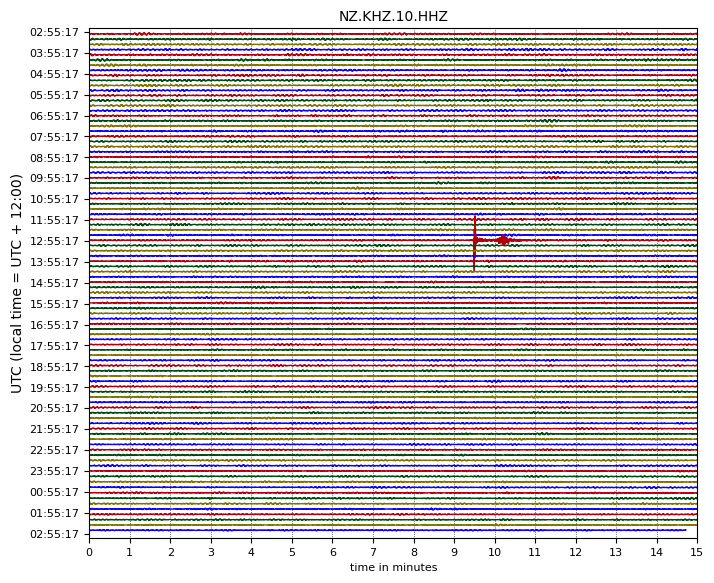

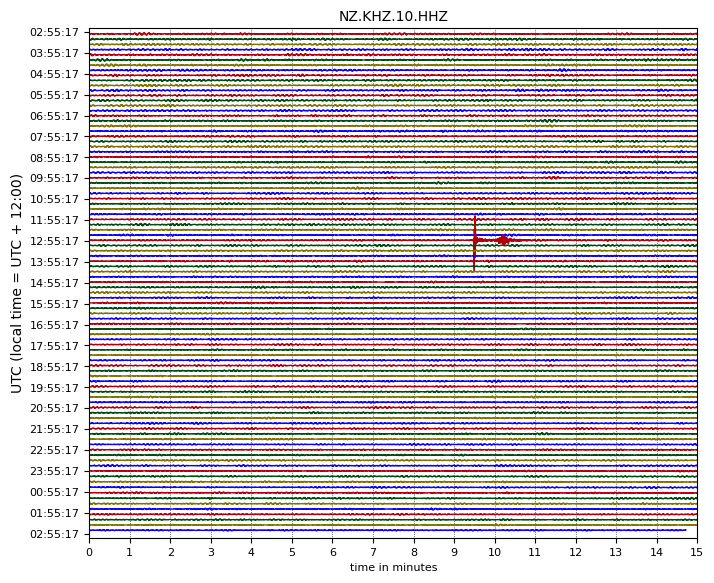

In [10]:
t = UTCDateTime.now()
st = client_nrt.get_waveforms("NZ", "KHZ", "10", "HHZ",t-86400,t)
st.plot(type="dayplot")

Based on the day plot, the data look continuous, but there might be small data gaps caused by communications issues. If this is the case, then the stream will consist of several traces

In [121]:
print(np.power(2.0,-1.2))

0.43527528164806206


We get some basic attributes to tell us a bit more about the first trace in the stream. If the stream consists of only one trace then this information will refer to the whole day of data requested.

In [12]:
print(st[0].stats)

               network: NZ
               station: KHZ
              location: 10
               channel: HHZ
             starttime: 2023-04-27T02:55:17.570000Z
               endtime: 2023-04-28T02:54:55.980000Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 8637842
                 calib: 1.0
_fdsnws_dataselect_url: https://service-nrt.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 20984, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 10743808})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 4, 28, 2, 55, 17, 570000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 4, 27, 2, 55, 17, 570000))']
